# <center> <b> <font color='blue'> Predictions </center> </b> </font>

## <font color='#1f618d'> Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Predictions](#3)
4. [Other ways to forecast](#4)
5. [Summary](#5)
6. [References](#References)

<a name="1"></a>
## <font color='#1f618d'> <b> 1. Introduction </font> </b>

The goal is to show how predictions should be made in a time series problem.

<a name="2"></a>
## <font color='#1f618d'> <b> 2. Setup </font> </b>

We will generate synthetic data, preprocess it, and train a simple model.


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

### Generating the data

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """An arbitrary pattern"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

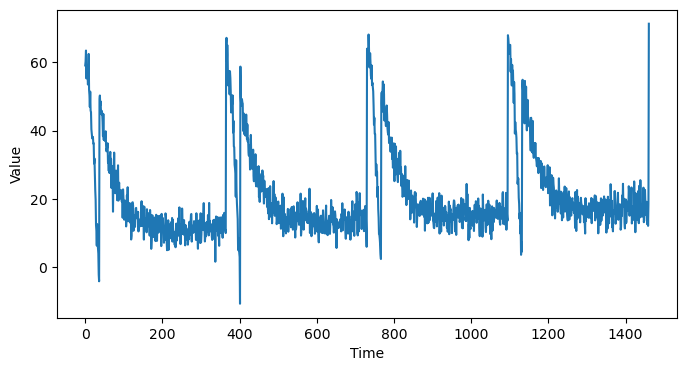

In [4]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series


# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 3
    HORIZON=1
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000
    

# Plot the generated series
plt.figure(figsize=(8, 4))
plot_series(G.TIME, G.SERIES)
plt.show()

### Processing the data

In [5]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [6]:
def windowed_dataset(series, 
                     window_size=G.WINDOW_SIZE, 
                     horizon=G.HORIZON, 
                     batch_size=32, 
                     shuffle_buffer=10,
                     shuffle=True):
    
    # Create the dataset from the series
    ds = tf.data.Dataset.from_tensor_slices(series)
    
    # Create windows of size (window_size + horizon)
    ds = ds.window(window_size + horizon, shift=1, drop_remainder=True)
    
    # Flatten the windows into batches
    ds = ds.flat_map(lambda w: w.batch(window_size + horizon))
    
    if shuffle:
        ds = ds.shuffle(shuffle_buffer)
    
    # Split the windows into features and labels
    ds = ds.map(lambda w: (w[:-horizon], w[-horizon:]))
    
    # Batch the dataset
    ds = ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# Apply the transformation to the training set and val set (horizon=1)
dataset_train = windowed_dataset(series_train)
dataset_val = windowed_dataset(series_valid, shuffle=False)

# Apply the transformation to the training set and val set (horizon=2)
dataset_train_2 = windowed_dataset(series_train, horizon=2)
dataset_val_2 = windowed_dataset(series_valid, horizon=2, shuffle=False)


### Training a model

In [7]:
tf.random.set_seed(51)

In [8]:
def create_uncompiled_model(horizon):
    
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(horizon),
        tf.keras.layers.Lambda(lambda x: x*100.0)
    ]) 

    return model

In [9]:
def create_model(horizon=1):

    model = create_uncompiled_model(horizon)

    model.compile(loss='mse',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=["mae"])  
    
    return model

In [10]:
model = create_model()

In [11]:
# Model 1 -> horizon=1
# train the model
history = model.fit(dataset_train,
                    epochs=50, 
                    verbose=0,
                    validation_data=dataset_val)

In [12]:
data = np.array([53.53772,   54.78016,   62.50613])
model.predict(data[np.newaxis])

1/1 [==============================] - 1s 984ms/step


array([[53.007687]], dtype=float32)

In [13]:
pred = model.predict(data[np.newaxis])
pred[0][0]

1/1 [==============================] - 0s 17ms/step


53.007687

### Horizon greater than 1

In [14]:
model2 = create_model(2)

In [15]:
history2 = model2.fit(dataset_train_2, 
                    epochs=50, 
                    verbose=0,
                    validation_data=dataset_val_2)

In [16]:
data = np.array([53.53772,   54.78016,   62.50613])
model2.predict(data[np.newaxis])

1/1 [==============================] - 1s 986ms/step


array([[53.216225, 51.169865]], dtype=float32)

In [17]:
pred = model2.predict(data[np.newaxis])
pred[0][0], pred[0][1]

1/1 [==============================] - 0s 17ms/step


(53.216225, 51.169865)

<a name="3"></a>
## <font color='#1f618d'> <b> 3. Predictions </font> </b>


### Window_size=3, horizon=1

The idea is:

- Take the initial window 
    - Which, when testing, corresponds to the last values (quantity = window size) of the training set.
- With this window, we generate a new prediction. 
- Then, we shift the window so that the last value becomes our first prediction, and we use this to predict the second value. 
- These steps are repeated until we obtain the desired number of predictions.
     - Which, when testing, is equal to the length of the validation set. 

Our first model is trained to predict one step ahead.

<img src="images/h1.png"/>

In [19]:
# how many time steps to predict into the future
into_future = 4

In [20]:
# Set print options to format floats with 2 decimal places
np.set_printoptions(formatter={'float': '{:.2f}'.format})

def forecast(model, initial_window, num_predictions, verbose=False):
    predictions = []
    current_window = initial_window.copy()  # Start with the initial window

    for _ in range(num_predictions):
        
        # Make a prediction based on the current window
        pred = model.predict(current_window[np.newaxis], verbose=0)
        predictions.append(pred[0][0])
        
        if verbose:
            print(f"Current window: {current_window}")
            print(f"Prediction: {pred[0][0]:.2f}")
            print("\n")

        # Update the window: remove the oldest value and add the new prediction
        current_window = np.roll(current_window, -1)  # Shift the window left
        current_window[-1] = pred[0][0]  # Add the new prediction at the end

    return np.array(predictions)

In [21]:
# let's generate a few predictions
initial_window = np.array([53.53772,   54.78016,   62.50613])

forecast(model, initial_window, into_future, True)

Current window: [53.54 54.78 62.51]
Prediction: 53.01


Current window: [54.78 62.51 53.01]
Prediction: 49.90


Current window: [62.51 53.01 49.90]
Prediction: 48.49


Current window: [53.01 49.90 48.49]
Prediction: 45.81




array([53.01, 49.90, 48.49, 45.81], dtype=float32)

To calculate the metrics:

- The initial window is composed of the last WINDOW_SIZE values from the training set.
- The number of predictions is equal to the length of the validation set.

In [22]:
series_train[-G.WINDOW_SIZE:]

array([65.18, 62.57, 63.61], dtype=float32)

In [23]:
preds = forecast(model, series_train[-G.WINDOW_SIZE:], len(series_valid))

In [24]:
# Calculate MAE directly using the metric function
mae = tf.keras.metrics.mean_absolute_error(series_valid, preds)
mae

<tf.Tensor: shape=(), dtype=float32, numpy=6.9451375>

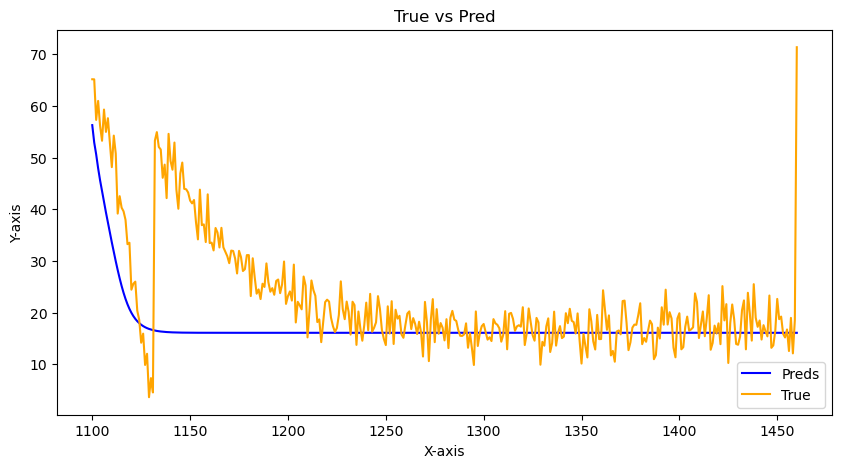

In [25]:
# Plotting
plt.figure(figsize=(10, 5))  # Optional: Set the figure size
plt.plot(time_valid, preds, label='Preds', color='blue')  # Plot the first array
plt.plot(time_valid, series_valid, label='True', color='orange')  # Plot the second array

# Adding labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('True vs Pred')
plt.legend()  # Show legend

# Show the plot
plt.show()

### Window_size=3, horizon=2

The idea is:

- Take the initial window 
    - Which, when testing, corresponds to the last values (quantity = window size) of the training set. 
- With whis window, we generate a new set of predictions based on the horizon (number of steps ahead the model predicts). 
- After making the predictions, we shift the window so that the last values of the predictions replace the oldest values in the window. 
- This process is repeated until we obtain the desired number of predictions.

Our second model is trained to predict 2 steps ahead.

<img src="images/h2.png"/>

In [27]:
# how many time steps to predict into the future
into_future = 4

We need to generalize our previous function for multi-step predictions:

In [28]:
def forecast(model, initial_window, num_predictions, horizon=G.HORIZON, verbose=False):
    """
    Forecast future values using a model with multi-step horizon predictions.
    
    Args:
        model: The trained model used for predictions.
        initial_window: The starting data window.
        num_predictions: The total number of steps to predict.
        horizon: The number of steps the model predicts in each iteration (e.g., 2 for 2 steps ahead).
        verbose: If True, prints details about the current window and predictions.
        
    Returns:
        A NumPy array of predicted values.
    """
    predictions = []
    current_window = initial_window.copy()  # Start with the initial window
    

    # Make predictions until the desired number is reached
    while len(predictions) < num_predictions:
        
        # Make a prediction for multiple steps ahead
        pred = model.predict(current_window[np.newaxis], verbose=0)
        pred_steps = pred[0][:horizon]  # Extract the predicted steps

        # Add the predictions to the list, but ensure we don't exceed num_predictions
        steps_to_add = min(horizon, num_predictions - len(predictions))
        predictions.extend(pred_steps[:steps_to_add])
        
        if verbose:
            print(f"Current window: {current_window}")
            print(f"Predictions: {pred_steps[:steps_to_add]}")
            print("\n")

        # Update the window: remove the oldest values and add the new predictions
        current_window = np.roll(current_window, -steps_to_add)  # Shift left by the number of steps added
        current_window[-steps_to_add:] = pred_steps[:steps_to_add]  # Insert the new predictions at the end

    return np.array(predictions[:num_predictions])  # Return exactly num_predictions values


In [29]:
# let's generate a few predictions
initial_window = np.array([53.53772,   54.78016,   62.50613])

forecast(model2, initial_window, into_future, 2, True)

Current window: [53.54 54.78 62.51]
Predictions: [53.22 51.17]


Current window: [62.51 53.22 51.17]
Predictions: [49.90 48.11]




array([53.22, 51.17, 49.90, 48.11], dtype=float32)

In [30]:
series_train[-G.WINDOW_SIZE:]

array([65.18, 62.57, 63.61], dtype=float32)

In [31]:
preds = forecast(model2, series_train[-G.WINDOW_SIZE:], len(series_valid))

In [32]:
# Calculate MAE directly using the metric function
mae = tf.keras.metrics.mean_absolute_error(series_valid, preds)
mae

<tf.Tensor: shape=(), dtype=float32, numpy=6.442354>

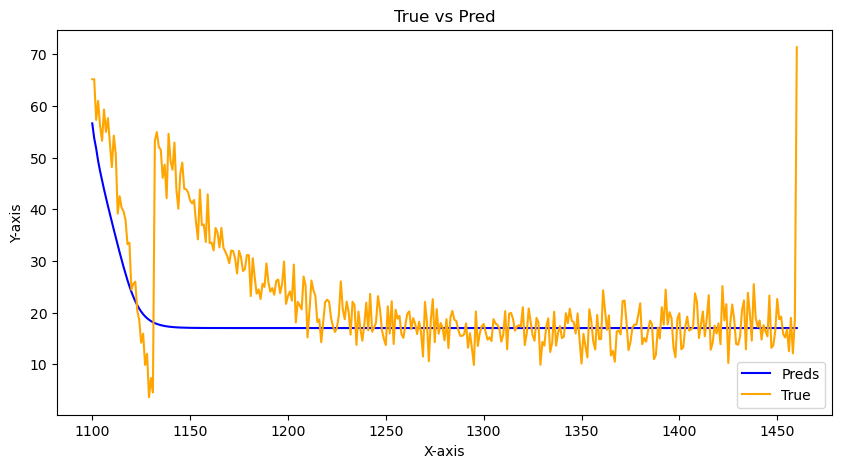

In [33]:
# Plotting
plt.figure(figsize=(10, 5))  # Optional: Set the figure size
plt.plot(time_valid, preds, label='Preds', color='blue')  # Plot the first array
plt.plot(time_valid, series_valid, label='True', color='orange')  # Plot the second array

# Adding labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('True vs Pred')
plt.legend()  # Show legend

# Show the plot
plt.show()

<a name="4"></a>
## <font color='#1f618d'> <b> 4. Other ways to forecast </font> </b>

### <font color='#2874a6'> Retrain the model using the new predictions </font>

#### Example with a Sliding Window Model:
Let’s say you are using a model with a sliding window size of 5. At time step `t`, the data window is `[x(t-4), x(t-3), x(t-2), x(t-1), x(t)]`.

- **Step 1**: Train the model and with the sliding window predict `x(t+1)`.
- **Step 2**: Once the actual value for `x(t+1)` is known, update the window: `[x(t-3), x(t-2), x(t-1), x(t), x(t+1)]`.
- **Step 3**: <font color='blue'> Retrain </font> the model with this updated window and predict `x(t+2)`.
- **Step 4**: Repeat this process as new observations come in.

**Note**: Instead of retraining with every new prediction, you could retrain the model periodically (e.g., after every 10, 50, or 100 new observations), depending on your available resources.


### <font color='#2874a6'> Direct Forecasting </font>

### Direct Forecasting

Is an approach used in time series forecasting where a separate model is trained for each future time step you want to predict. Instead of using the predicted value of one time step as input for the next (like in recursive forecasting), each model is independent and predicts a specific future time step directly. Here’s how it works:

#### Key Concepts of Direct Forecasting:

1. **Separate Models for Each Horizon**:
   - For each forecast horizon (e.g., `t+1`, `t+2`, `t+3`, etc.), you train a separate model. For example, if you want to predict up to `t+5`, you would train five different models: one for predicting `t+1`, one for `t+2`, and so on.

2. **No Recursive Predictions**:
   - Unlike recursive forecasting, where predictions are fed back into the model as inputs for future predictions, direct forecasting models predict each time step independently using only historical data.

3. **Data Representation**:
   - For each model, the input features consist of the historical time series data, and the output is the value of the time series at a specific future time step. For example:
     - Model 1: Predict `y(t+1)` using inputs from `[y(t), y(t-1), y(t-2), ...]`.
     - Model 2: Predict `y(t+2)` using inputs from `[y(t), y(t-1), y(t-2), ...]`.

4. **Advantages**:
   - **Accuracy for Each Horizon**: Since each model is optimized for a specific future time step, it can potentially achieve better accuracy for that particular horizon than a recursive model that accumulates prediction errors.
   - **No Error Propagation**: Direct forecasting avoids error accumulation, a common issue in recursive forecasting. In recursive methods, errors in earlier predictions can compound and negatively affect later predictions.
   - **More Flexibility**: You can use different types of models for different forecast horizons. For example, a short-term model (`t+1`) might benefit from a linear regression approach, while a longer-term model (`t+5`) could use a more complex non-linear method.

5. **Disadvantages**:
   - **More Computationally Intensive**: Since you need to train a separate model for each forecast horizon, direct forecasting can be more computationally expensive than recursive forecasting.
   - **More Complex**: Managing and maintaining multiple models can be more complex, especially if you are forecasting many future time steps.
   - **Reduced Data**: For long-term horizons, the training data for later models (`t+5`, for example) might be smaller since fewer examples will have a valid label that far ahead in the future.

#### Example of Direct Forecasting:

Let’s assume you have a time series of daily temperature data and you want to predict the temperature for the next 3 days (`t+1`, `t+2`, `t+3`).

1. **Model 1 (for `t+1`)**:
   - Train the model to predict the temperature at `t+1` using the historical data from `[t, t-1, t-2, ...]`.

2. **Model 2 (for `t+2`)**:
   - Train the model to predict the temperature at `t+2` using the historical data from `[t, t-1, t-2, ...]`. This model doesn’t rely on the prediction of `t+1`, making it independent.

3. **Model 3 (for `t+3`)**:
   - Similarly, train the model to predict the temperature at `t+3` using the same historical data, without using any predicted values from earlier time steps.

#### When to Use Direct Forecasting:

- **When You Want High Accuracy for Specific Horizons**: If you are particularly interested in getting the most accurate prediction for certain future steps (like `t+1` and `t+3`), direct forecasting can give you more control.
- **To Avoid Error Propagation**: If your time series is highly sensitive to accumulated prediction errors (such as financial data or volatile time series), direct forecasting may offer better stability.
- **When You Have Sufficient Data and Resources**: Since training multiple models is resource-intensive, direct forecasting is a good fit if you have enough data and computational power to handle separate models for each horizon.

#### Summary:

Direct forecasting offers a structured way to predict future time steps without relying on previous predictions. It can improve accuracy by focusing models on specific horizons and avoids compounding errors, but comes at the cost of more complexity and higher computational demands. This method can be especially useful for tasks like financial forecasting, energy consumption prediction, or any scenario where each prediction horizon has different characteristics.


<a name="5"></a>
## <font color='#1f618d'> <b> 5. Summary </font> </b>

We can use the following function to make predictions:

In [74]:
def forecast(model, initial_window, num_predictions, horizon=G.HORIZON, verbose=False):
    """
    Forecast future values using a model with multi-step horizon predictions.
    
    Args:
        model: The trained model used for predictions.
        initial_window: The starting data window.
        num_predictions: The total number of steps to predict.
        horizon: The number of steps the model predicts in each iteration (e.g., 2 for 2 steps ahead).
        verbose: If True, prints details about the current window and predictions.
        
    Returns:
        A NumPy array of predicted values.
    """
    predictions = []
    current_window = initial_window.copy()  # Start with the initial window
    

    # Make predictions until the desired number is reached
    while len(predictions) < num_predictions:
        
        # Make a prediction for multiple steps ahead
        pred = model.predict(current_window[np.newaxis], verbose=0)
        pred_steps = pred[0][:horizon]  # Extract the predicted steps

        # Add the predictions to the list, but ensure we don't exceed num_predictions
        steps_to_add = min(horizon, num_predictions - len(predictions))
        predictions.extend(pred_steps[:steps_to_add])
        
        if verbose:
            print(f"Current window: {current_window}")
            print(f"Predictions: {pred_steps[:steps_to_add]}")
            print("\n")

        # Update the window: remove the oldest values and add the new predictions
        current_window = np.roll(current_window, -steps_to_add)  # Shift left by the number of steps added
        current_window[-steps_to_add:] = pred_steps[:steps_to_add]  # Insert the new predictions at the end

    return np.array(predictions[:num_predictions])  # Return exactly num_predictions values


<a name="References"></a>
## <font color='#1a5276'> <b> 6. References </font> </b>

[DeepLearning.AI TensorFlow Developer Professional Certificate](https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction?specialization=tensorflow-in-practice)

[TensorFlow for Deep Learning Bootcamp](https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/?couponCode=MTST7102224B2)